In [1]:
import pandas as pd
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999

In [2]:
radios = gpd.read_file('./radios_IGN_2010_WGS84/')

In [3]:

from pathlib import Path

p = Path('./mapaelectoral/geojson_CNE/')

result_list = []

for file in p.glob('**/*'):
    if 'circuito' in file.name:
        print(file.name)
        gdf_cne = gpd.read_file('./mapaelectoral/geojson_CNE/'+file.name)
        
#         if (gdf_cne.shape != (0, 1)) & (file.name != 'circuitos_04.geojson'): ## Si el archivo esta OK
        if gdf_cne.shape != (0, 1): ## Si el archivo esta OK
            print(gdf_cne.provincia.unique())
        
            ## Correccion de errores
            gdf_cne.loc[gdf_cne.departamen == 'Colon', 'indec_d'] = '008'
            gdf_cne.loc[gdf_cne.departamen == 'Concordia', 'indec_d'] = '015'
            gdf_cne.loc[gdf_cne.departamen == 'Villaguay', 'indec_d'] = '113'
            gdf_cne.loc[gdf_cne.departamen == 'Pehuenches', 'indec_d'] = '091'
            gdf_cne.loc[gdf_cne.departamen == 'Cañuelas', 'indec_d'] = '134'
            gdf_cne.loc[gdf_cne.departamen == 'Esteban Echeverria', 'indec_d'] = '260'
            gdf_cne.loc[gdf_cne.departamen == 'Florencio Varela', 'indec_d'] = '274'
            gdf_cne.loc[gdf_cne.departamen == 'Magdalena', 'indec_d'] = '505'
            gdf_cne.loc[gdf_cne.departamen == 'Morón', 'indec_d'] = '568'
            gdf_cne.loc[gdf_cne.departamen == 'Pilar', 'indec_d'] = '638'
            gdf_cne.loc[gdf_cne.departamen == 'San Vicente', 'indec_d'] = '778'
            gdf_cne.loc[gdf_cne.departamen == '12 de Octubre', 'indec_d'] = '036'
            gdf_cne.loc[(gdf_cne.provincia == 'Chaco')
                        & (gdf_cne.departamen == 'Almirante Brown'), 'indec_d'] = '043'

            
            radios_prov = radios.loc[radios.PROV_ == gdf_cne.indec_p.unique()[0]]
            
            ## Correccion de errores
            radios_prov.loc[radios_prov.IN1 == '26028', 'DEPTO_'] = '063' # Esto es para adaptarse a un erorr en CNE
#             (la CNE tiene unido camarones al dpto martires, por error)
            
            result_prov = []

#             for dpto in radios_prov.DEPTO_.unique():
            for dpto in gdf_cne.indec_d.unique():
                
                if (file.name == 'circuitos_06.geojson') | (file.name == 'circuitos_24.geojson'):
#                     print('chaco o tdf')
                    radios_dpto = radios_prov # En chaco y tdf, usar toda la provincia porque los codigos estan cambiados...
                else:
                    radios_dpto = radios_prov.loc[radios_prov.DEPTO_ == dpto]
                    
                circ_dpto = gdf_cne.loc[gdf_cne.indec_d == dpto]

                ## Intersectar los radios en cuestion con los polis de IGS.
                inters = gpd.overlay(radios_dpto, circ_dpto[['circuito', 'geometry']], how='intersection')
                if len(inters) != 0: # Si hay interseccion
                    inters['area'] = inters.area

                    year = '2010'
                    # Quedarse con el que mas interseca (el radio se asigna al depto donde este mayor parte de su area.)
                    radios_in_circu = inters.groupby(['PROV_', 'DEPTO_', 'FRACC_', 'COD_'+year]).apply(lambda x: x.nlargest(1, 'area')).reset_index(drop = True)[['PROV_', 'DEPTO_', 'FRACC_', 'COD_'+year, 'IN1', 'circuito']]
                    # radios_in_circu['FRACC_2'] = radios_in_circu['COD_'+year].str[5:7]
                    result_prov += [radios_in_circu]
                else:
                    print('sin interseccion en '+str(circ_dpto.departamen.unique()[0]))

            result_prov = pd.concat(result_prov)
            
            
            
            ## Tomar radios que se asociaron a mas de 1 circuito. Esto pasa cuando se usa la provincia entera para intersecar (ej. chaco)
            duplicados = result_prov[result_prov.duplicated('COD_2010', keep = False)].sort_values('COD_2010')

            if len(duplicados) > 0:

                ## Volcarlos en 1 solo circuito.
                inters = gpd.overlay(gpd.GeoDataFrame(duplicados.drop('circuito', axis = 1).merge(radios)), 
                                     gpd.GeoDataFrame(duplicados.merge(gdf_cne))[['circuito', 'geometry']], how='intersection')

                if len(inters) != 0: # Si hay interseccion
                    inters['area'] = inters.area

                    year = '2010'
                    # Quedarse con el que mas interseca (el radio se asigna al depto donde este mayor parte de su area.)
                    res_dup_prov = inters.groupby(['PROV_', 'DEPTO_', 'FRACC_', 'COD_'+year]
                                                ).apply(lambda x: x.nlargest(1, 'area')
                                                       ).reset_index(drop = True)[['PROV_', 'DEPTO_', 'FRACC_', 'COD_'+year, 'IN1', 'circuito']]
                result_prov = pd.concat([result_prov[~result_prov.duplicated('COD_2010', keep = False)], res_dup_prov])
    
    result_list += [result_prov]

result = pd.concat(result_list).drop_duplicates()


circuitos_13.geojson
['Mendoza']
0
circuitos_17.geojson
['Salta']
0
circuitos_08.geojson
['Entre Rios']
0
circuitos_09.geojson
circuitos_11.geojson
['La Pampa']
0
circuitos_01.geojson
['Ciudad Áutonoma de Buenos Aires']
0
circuitos_10.geojson
['Jujuy']
0
circuitos_07.geojson
['Chubut']
0
circuitos_05.geojson
['Corrientes']
0
circuitos_03.geojson
['Catamarca']
0
circuitos_15.geojson
['Neuquen']
0
circuitos_04.geojson
['Córdoba']
0
circuitos_16.geojson
['Río Negro']
0
circuitos_23.geojson
['Tucumán']
0
circuitos_18.geojson
['San Juan']
0
circuitos_19.geojson
['San Luis']
0
circuitos_24.geojson
['Tierra del Fuego, Antártida e Islas del Atlántico Sur']
sin interseccion en Islas del Atlantico Sur
sin interseccion en Antartida Argentina
19
155
9
circuitos_20.geojson
circuitos_21.geojson
['Santa Fe']
0
circuitos_02.geojson
['Buenos Aires']
0
circuitos_14.geojson
['Misiones']
0
circuitos_12.geojson
circuitos_06.geojson
['Chaco']
485
1481
221


In [4]:
pob_radios = pd.read_csv('./pob2010')#[['COD_2010', 'n_PERSONA_REF_ID']]
pob_radios['COD_2010'] = pob_radios['radio'].astype(str).str.zfill(9)
pob_radios['PROV_'] = pob_radios['COD_2010'].str[:2]


In [14]:
result_pob = result.merge(pob_radios, how = 'left')

pob = pd.concat([pob_radios.groupby(['PROV_'])[['TOTAL']].sum(),
          result_pob.groupby(['PROV_'])[['TOTAL']].sum()], axis = 1).fillna(0).astype(int)

print(round(100*pob.sum().iloc[1]/pob.sum().iloc[0], 1))

pob['pct'] = round(100*pob.iloc[:, 1]/pob.iloc[:, 0], 1)
pob

89.5


,TOTAL,TOTAL,pct
02,2890151,2890151,100.0
06,15625084,15624927,100.0
10,367828,367828,100.0
14,3308876,1322700,40.0
18,992595,992595,100.0
22,1055259,1051885,99.7
26,509108,508808,99.9
30,1235994,1235994,100.0
34,530162,0,0.0
38,673307,673307,100.0


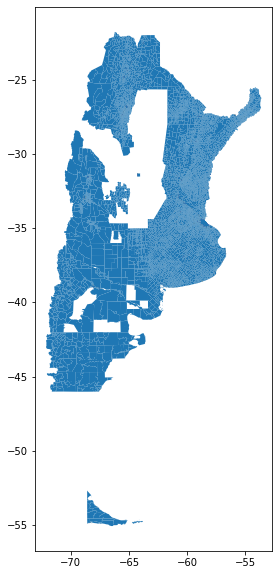

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, figsize = (7, 10))

gpd.GeoDataFrame(result.merge(radios[['PROV_', 'DEPTO_', 'FRACC_', 'COD_2010', 'geometry']])).plot(ax = ax)

plt.show()

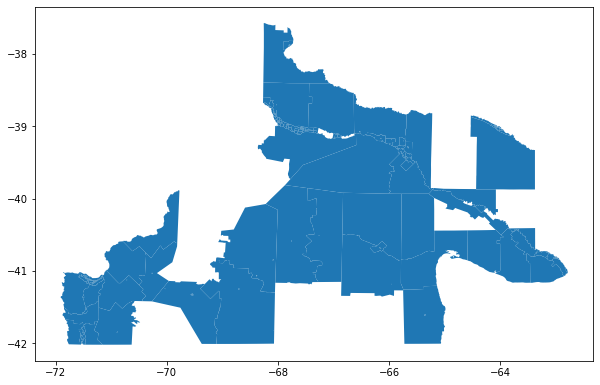

In [16]:
fig, ax = plt.subplots(1, figsize = (10, 10))

gpd.GeoDataFrame(result.loc[result.PROV_ == '62'].merge(radios[['PROV_', 'DEPTO_', 'FRACC_', 'COD_2010', 'geometry']])).plot(ax = ax)

plt.show()

In [19]:
result.to_csv('./radios_circuitos.csv', index = False)

In [ ]:
xx